## Observations and Insights 

Summary of Capomulin treatment regimen for squamous cell carcinoma (SCC) as compared to other treatment regimens:

* The study reviewed the progress of 249 mice with about an even split between male (50.2%) and female (49.8%) mice.

* Capomulin was one of two treatment regimens that had the most measurements (230) taken over the course of the study. The treatment with the next highest measurement count was Ramicane at 228.

* Of the four regimens depicted, Capomulin and Ramicane have the lowest final tumor volumes in mice. Capomulin had a median final tumor volume of 38 and Ramicane had a median of 36.5. 

* While Capomulin is effective at reducing tumor volume, it may not reduce the spread of SCC. Mouse l509 saw an increase in metastatic sites as their tumor volume decreased throughout the treatment regimen. 

* There is a strong positive correlation (r=0.95) between average tumor volume and mouse weight. It may be beneficial to look at other factors that affect weight that could help treat and reduce tumor volume in patients with SCC.

## Cleaning Data

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)


In [2]:
# Combine the data into a single dataset
combinedData = mouse_metadata.merge(study_results)

In [3]:
# Checking the number of mice.
mouseCount = len(combinedData["Mouse ID"].unique())

In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
combinedData["Duplicated"] = combinedData.duplicated(subset=["Mouse ID","Timepoint"])
dups = combinedData.loc[combinedData["Duplicated"]==True,:]

In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
dupMouse = combinedData.loc[combinedData["Mouse ID"]=="g989",:]

In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
cleanedData = combinedData.drop_duplicates(subset=["Mouse ID","Timepoint"])
cleanedData= cleanedData[['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)',
       'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites']]

In [7]:
# Checking the number of mice in the clean DataFrame.
cleanMouseCount = len(cleanedData["Mouse ID"].unique())
if cleanMouseCount != mouseCount:
    print(f'Oops, the mouse count is off.')

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
regimenGroupsAgg = cleanedData.groupby("Drug Regimen").agg({"Tumor Volume (mm3)":['mean','median','var','std','sem']})
regimenGroupsAgg

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.393463  50.909965  43.138803  6.568014  0.525862
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

Text(0, 0.5, 'Number of Measurements')

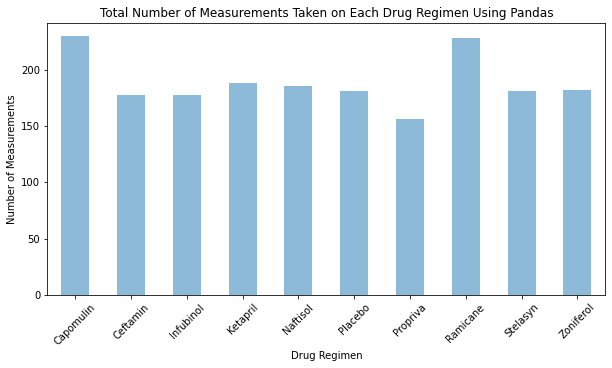

In [9]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.

regimenMeasurements = cleanedData.groupby("Drug Regimen").agg({"Timepoint":'count'})

pandasMeasurements = regimenMeasurements.plot.bar(figsize=(10,5), alpha=0.5, align="center", legend=False, title="Total Number of Measurements Taken on Each Drug Regimen Using Pandas")
pandasMeasurements.set_xticklabels(regimenMeasurements.index, rotation=45)
plt.ylabel("Number of Measurements")

Text(0, 0.5, 'Number of Measurements')

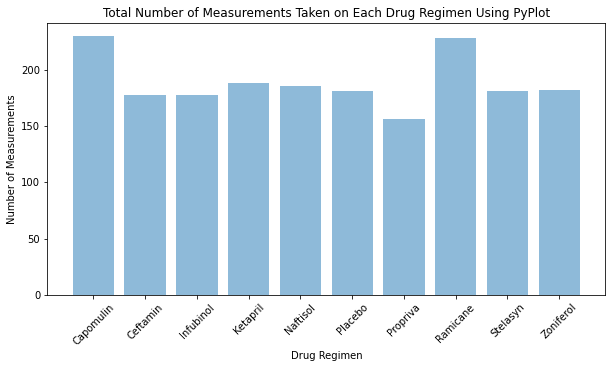

In [10]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = np.arange(len(regimenMeasurements.index))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,5))
plt.bar(x_axis,regimenMeasurements.Timepoint, alpha=0.5, align="center")
plt.xticks(tick_locations, regimenMeasurements.index, rotation=45)
plt.title("Total Number of Measurements Taken on Each Drug Regimen Using PyPlot")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Measurements")

In [11]:
#Get Distribution of female vs male mice
# use agg method and don't use sex as an index so we can use the column later in the pie chart
mouseGender = cleanedData.groupby(by="Sex", as_index=False).agg({"Mouse ID": pd.Series.nunique})
mouseGender.columns = ["Sex","Number of Mice"]
mouseGender["Percent of Mice"] = round((mouseGender["Number of Mice"]/cleanMouseCount)*100,2)

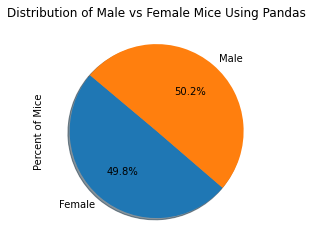

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
pandasGender = mouseGender[["Sex","Percent of Mice"]]
pandasGender = pandasGender.set_index("Sex")
pandasGender.plot.pie(y='Percent of Mice', title="Distribution of Male vs Female Mice Using Pandas", legend=False, autopct='%1.1f%%',shadow = True, startangle = 140)

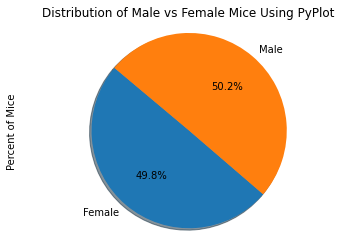

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
labels = mouseGender["Sex"].tolist()
sizes = mouseGender["Percent of Mice"].tolist()
plt.pie(sizes, labels = labels, autopct='%1.1f%%',shadow = True, startangle = 140)
plt.axis("equal")
plt.title("Distribution of Male vs Female Mice Using PyPlot")
plt.ylabel("Percent of Mice")
plt.show()

## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
lastTimepointPerMouse = cleanedData.groupby("Mouse ID").agg({"Timepoint":'max'})

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
finalTumorVolume_df = pd.merge(lastTimepointPerMouse,cleanedData, how='left', on=['Mouse ID','Timepoint'])


In [15]:
# Put treatments into a list for for loop (and later for plot labels)
regimens = ['Capomulin', 'Ramicane', 'Infubinol','Ceftamin']

tumorVolumes = {}
regimenQtiles = {}
regimenBounds = {}


for regimen in regimens:
    regimenTumorVolume = finalTumorVolume_df.loc[finalTumorVolume_df["Drug Regimen"]==regimen,:]
    
    #save regimen tumor volume series and calculate quartiles, iqr, and upper and lower bounds
    regTumVol = regimenTumorVolume["Tumor Volume (mm3)"]
    quartiles = regTumVol.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lowerb = lowerq - (1.5*iqr)
    upperb = upperq + (1.5*iqr)
    
    #save all regimen data to dicts
    tumorVolumes[regimen] = regTumVol
    regimenQtiles[regimen] = {
        "quartiles" : quartiles,
        "lowerq" : lowerq,
        "upperq" : upperq,
        "iqr" : iqr,
        "median": quartiles[0.5]
    }
    regimenBounds[regimen] = {
        "lower_bound" : lowerb,
        "upper_bound" : upperb 
    }
    
  
    
    #print output
    print(f'''
    Processing {regimen}...
    The lower quartile of tumor volumes is: {regimenQtiles[regimen]["lowerq"]}
    The upper quartile of tumor volumes is: {regimenQtiles[regimen]["upperq"]}
    The interquartile range of tumor volumes is: {regimenQtiles[regimen]["iqr"]}
    The median of tumor volumes is: {regimenQtiles[regimen]["median"]}
    Values above {regimenBounds[regimen]["upper_bound"]} could be outliers.
    Values below {regimenBounds[regimen]["lower_bound"]} could be outliers.
    ''')




    Processing Capomulin...
    The lower quartile of tumor volumes is: 32.37735684
    The upper quartile of tumor volumes is: 40.1592203
    The interquartile range of tumor volumes is: 7.781863460000004
    The median of tumor volumes is: 38.125164399999996
    Values above 51.83201549 could be outliers.
    Values below 20.70456164999999 could be outliers.
    

    Processing Ramicane...
    The lower quartile of tumor volumes is: 31.56046955
    The upper quartile of tumor volumes is: 40.65900627
    The interquartile range of tumor volumes is: 9.098536719999998
    The median of tumor volumes is: 36.56165229
    Values above 54.30681135 could be outliers.
    Values below 17.912664470000003 could be outliers.
    

    Processing Infubinol...
    The lower quartile of tumor volumes is: 54.04860769
    The upper quartile of tumor volumes is: 65.52574285
    The interquartile range of tumor volumes is: 11.477135160000003
    The median of tumor volumes is: 60.16518046
    Values 

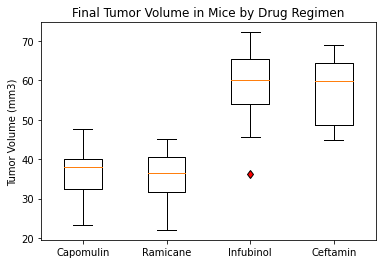

Of the four regimens depicted, Capomulin and Ramicane have the lowest final tumor volumes in mice.
There is one outlier for Infubinol with a Tumor Volume of 36.32mm3.


In [16]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
outliersF = dict(markerfacecolor='r', marker='d')
fig1, ax1 = plt.subplots()
ax1.set_title("Final Tumor Volume in Mice by Drug Regimen")
ax1.set_ylabel("Tumor Volume (mm3)")
ax1.boxplot(tumorVolumes.values(), flierprops=outliersF)
ax1.set_xticklabels(tumorVolumes.keys())

plt.show()

# find outlier
tumorVolumes["Infubinol"].sort_values()
infubinolOutlier = tumorVolumes["Infubinol"].min()

# print observation
print(f'Of the four regimens depicted, Capomulin and Ramicane have the lowest final tumor volumes in mice.')
print(f'There is one outlier for Infubinol with a Tumor Volume of {round(infubinolOutlier,2)}mm3.')

## Line and Scatter Plots

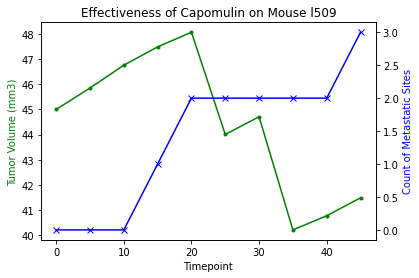

While Capomulin is effective at reducing tumor volume, Mouse l509 saw an increase in metastatic sites.


In [17]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

# use loc to filter cleanedData for all data associated with mouse l509
capomulinMouse = cleanedData.loc[cleanedData["Mouse ID"]=="l509",:]

# set x_axis and tumor volume series 
# -- added in metastatic sites because reviewing data showed that number of sites rose as tumor volume decreased. I thought it was interesting.
x_axis = capomulinMouse["Timepoint"]
mouseTumorVolume = capomulinMouse["Tumor Volume (mm3)"]
mouseMetastaticSites = capomulinMouse["Metastatic Sites"]

# create figure with subplots for two lines and plot lines with a secondary y axis and axis titles color coded to line color instead of legend
fig2, ax1 = plt.subplots()
ax1.plot(x_axis,mouseTumorVolume, marker='.', color='green', label='Tumor Volume')
ax1.set_title("Effectiveness of Capomulin on Mouse l509")
ax1.set_xlabel("Timepoint")
ax1.set_ylabel("Tumor Volume (mm3)", color='green')
ax2=ax1.twinx()
ax2.plot(x_axis,mouseMetastaticSites, marker='x', color='blue', label='Metastatic Sites')
ax2.set_ylabel("Count of Metastatic Sites", color='blue')
plt.show()

# print observation
print(f'While Capomulin is effective at reducing tumor volume, Mouse l509 saw an increase in metastatic sites.')

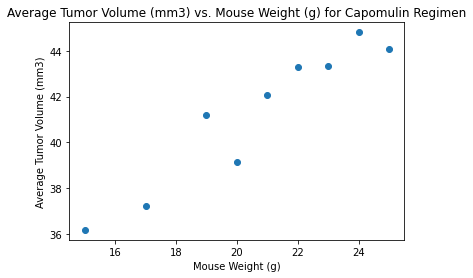

As mouse weight increases so does tumor volume.


In [18]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

# get only data for capomulin from cleaned data
capomulinData = cleanedData.loc[cleanedData["Drug Regimen"]=="Capomulin",:]

# group capomulinData by weight, leaving an index so we can use the weight column in the scatter plot. 
# also use agg method to get the average tumor volume
weightTumorVol = capomulinData.groupby("Weight (g)", as_index=False).agg({"Tumor Volume (mm3)":'mean'})

#set up scatter plot
x_values = weightTumorVol["Weight (g)"]
y_values = weightTumorVol["Tumor Volume (mm3)"]
plt.scatter(x_values,y_values)
plt.title("Average Tumor Volume (mm3) vs. Mouse Weight (g) for Capomulin Regimen")
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')
plt.show()

# print observation
print(f'As mouse weight increases so does tumor volume.')

## Correlation and Regression

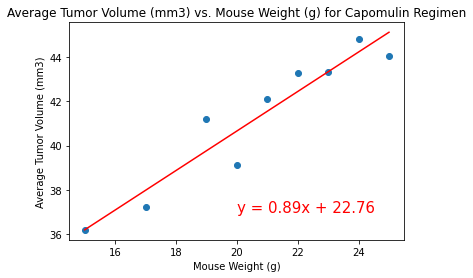

The r-squared is: 0.9034966277438606
The correlation coefficient is 0.95
There is a strong positive correlation between average tumor volume and mouse weight.


In [19]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

# linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# add to previous plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,37),fontsize=15,color="red")
plt.title("Average Tumor Volume (mm3) vs. Mouse Weight (g) for Capomulin Regimen")
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Average Tumor Volume (mm3)')
plt.show()

print(f"The r-squared is: {rvalue**2}")

# calculate correlation
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation coefficient is {round(correlation[0],2)}")

# print observations
print(f"There is a strong positive correlation between average tumor volume and mouse weight.")